### denoising diffusion probabilistic model

## Data

In [7]:
import io, re, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df=pd.read_parquet("../datos/faithful_1.21.1_32.parquet")
print(device)

img_size=32

cuda


## Code

In [8]:
def mostrar_resultados(resultados):
    """
    Muestra una lista de imágenes generadas con sus etiquetas.
    """
    plt.figure(figsize=(8, 2))
    for i, (img, label) in enumerate(resultados):
        plt.subplot(1, len(resultados), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.tight_layout()
    plt.show()

def generar_imagenes(modelo, txt_emb, prompt: str, n_samples=4, device="cuda"):
    
    modelo.eval()
    txt_emb.eval()
    with torch.no_grad():
        # Embedding condicional del texto
        cond_emb = txt_emb([prompt] * n_samples).to(device)

        # Ruido aleatorio
        x = torch.randn(n_samples, 3, img_size, img_size, device=device)

        #  Parámetros del modelo (difusión)
        betas = modelo.betas.to(device)
        alphas = modelo.alphas.to(device)
        alphas_cumprod = modelo.alphas_cumprod.to(device)
        timesteps = modelo.timesteps

        # generar imagenes
        for t in reversed(range(timesteps)):
            t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)
            noise_pred = modelo(x, t_tensor, cond_emb)

            beta_t = betas[t]
            alpha_t = alphas[t]
            alpha_bar_t = alphas_cumprod[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (
                (1 / torch.sqrt(alpha_t))
                * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * noise_pred)
                + torch.sqrt(beta_t) * noise
            )
        # normalizar
        x = (x * 0.5 + 0.5).clamp(0, 1)

        # Convertir a PIL y devolver
        results = []
        for i in range(n_samples):
            img_pil = TF.to_pil_image(x[i])
            results.append((img_pil, prompt))
    
    return results

# Dataset único (con augment)
class MinecraftDataset(Dataset):
    def __init__(self, rows: List[dict], image_size=img_size, augment=False):
        self.rows = rows
        self.image_size = image_size
        self.augment = augment
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)])

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows[idx]
        img = Image.open(io.BytesIO(r["image"]["bytes"])).convert("RGB")
        img_t = self.transform(img)
        if self.augment and torch.rand(1).item() > 0.5:
            img_t = torch.flip(img_t, dims=[2])
        label = r["label"]
        return img_t, label


# Embedding textual (por palabra)
class TextEmbedding(nn.Module):
    def __init__(self, vocab, embed_dim=100):
        super().__init__()
        self.vocab = vocab
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.embedding = nn.Embedding(len(vocab), embed_dim)

    @staticmethod
    def build_vocab(labels):
        words = set()
        for lbl in labels:
            for w in re.findall(r"\w+", lbl.lower()):
                words.add(w)
        return sorted(words)

    def forward(self, label_texts: List[str]):
        device = next(self.embedding.parameters()).device
        vectors = []
        for text in label_texts:
            tokens = [w for w in re.findall(r"\w+", text.lower()) if w in self.stoi]
            if not tokens:
                tokens = ["unknown"]
            idxs = torch.tensor([self.stoi[w] for w in tokens], device=device)
            emb = self.embedding(idxs).mean(dim=0)
            vectors.append(emb)
        return torch.stack(vectors)

#### Crear Modelo

In [9]:
# Bloques básicos
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, cond_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_fc = nn.Linear(1, out_ch)
        self.cond_fc = nn.Linear(cond_dim, out_ch)
        self.norm = nn.BatchNorm2d(out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t, cond):
        h = F.silu(self.conv1(x))
        t_emb = self.time_fc(t.unsqueeze(-1)).view(t.size(0), -1, 1, 1)
        c_emb = self.cond_fc(cond).view(cond.size(0), -1, 1, 1)
        h = h + t_emb + c_emb
        h = F.silu(self.norm(self.conv2(h)))
        return h + self.skip(x)


class MiniUNet(nn.Module): # más profunda que la de 16x16
    def __init__(self, cond_dim=128, base_ch=64, timesteps=100):
        super().__init__()
        self.timesteps = timesteps
        # Parámetros de difusión (no entrenables)
        self.register_buffer("betas", torch.linspace(1e-4, 0.02, timesteps))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alphas_cumprod", torch.cumprod(self.alphas, dim=0))

        # Encoder
        self.down1 = ResidualBlock(3, base_ch, cond_dim)
        self.down2 = ResidualBlock(base_ch, base_ch * 2, cond_dim)
        self.down3 = ResidualBlock(base_ch * 2, base_ch * 4, cond_dim)
        self.pool = nn.AvgPool2d(2)

        # Middle
        self.mid1 = ResidualBlock(base_ch * 4, base_ch * 4, cond_dim)
        self.mid2 = ResidualBlock(base_ch * 4, base_ch * 4, cond_dim)

        # Decoder
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.up3 = ResidualBlock(base_ch * 4, base_ch * 2, cond_dim)
        self.up2 = ResidualBlock(base_ch * 2, base_ch, cond_dim)
        # self.up1 = ResidualBlock(base_ch, base_ch, cond_dim)
        self.out = nn.Conv2d(base_ch, 3, 1)

    def forward(self, x, t, cond):
        # Normalizar t en [0,1]
        t = t.float() / self.timesteps

        h1 = self.down1(x, t, cond)
        h2 = self.down2(self.pool(h1), t, cond)
        h3 = self.down3(self.pool(h2), t, cond)

        h_mid1 = self.mid1(h3, t, cond)
        h_mid2 = self.mid2(h_mid1, t, cond)

        h = self.up(h_mid2)
        h = self.up3(h, t, cond)
        h = self.up(h)
        h = self.up2(h, t, cond)
        # h = self.up(h)
        # h = self.up1(h, t, cond)
        out = self.out(h)
        return out

In [4]:
embed_dim = 100      # dimensión del embedding textual

timesteps = 20       
ch_base = 96          # modelo más grande 

batch_size = 32
lr = 5e-4 #lr para finetuning 

In [5]:
# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))
vocab = TextEmbedding.build_vocab(all_labels)

print(f" Vocabulario generado con {len(vocab)} palabras únicas:")
# print(vocab)

# Dataset y DataLoader
dataset = MinecraftDataset(df.to_dict("records"), image_size=img_size, augment=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


 Vocabulario generado con 350 palabras únicas:


#### Entrenamiento

In [6]:
# MODELOS 
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim).to(device)
model = MiniUNet(cond_dim=embed_dim, base_ch=ch_base, timesteps=timesteps).to(device)

In [7]:
optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': lr},
    {'params': txt_emb.parameters(), 'lr': lr * 0.5}  #menor learning rate para el text embedder
])


Epoch 0/2000 | Loss: 0.1204


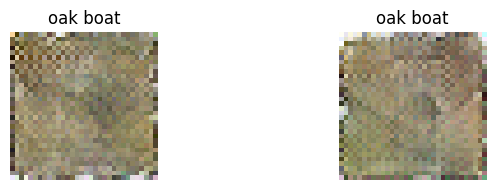

Epoch 100/2000 | Loss: 0.1179


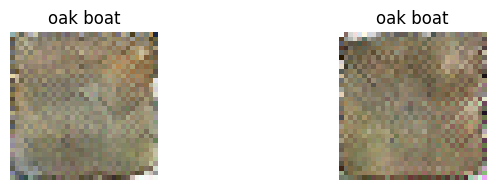

Epoch 200/2000 | Loss: 0.1147


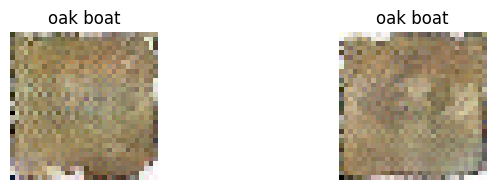

Epoch 300/2000 | Loss: 0.1033


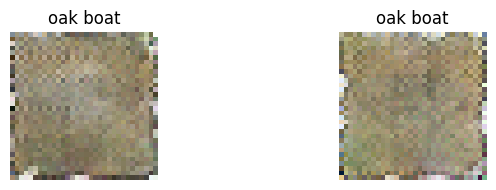

Epoch 400/2000 | Loss: 0.1039


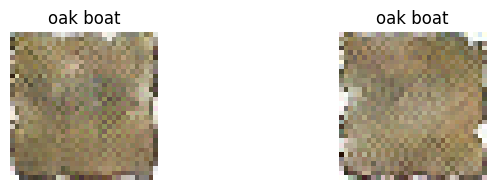

Epoch 500/2000 | Loss: 0.1028


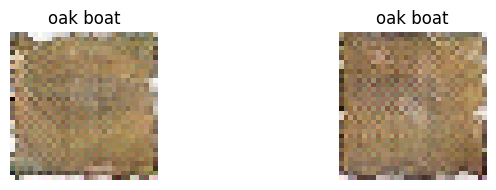

Epoch 600/2000 | Loss: 0.0983


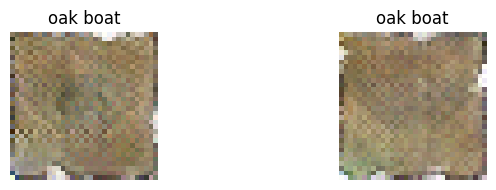

Epoch 700/2000 | Loss: 0.1175


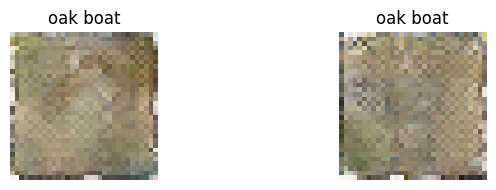

Epoch 800/2000 | Loss: 0.0931


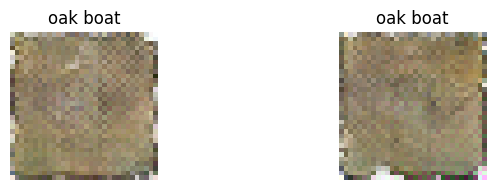

Epoch 900/2000 | Loss: 0.0960


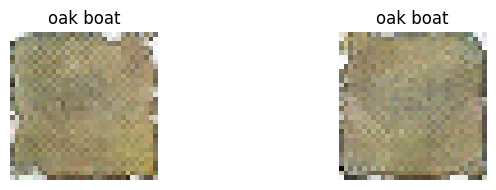

Epoch 1000/2000 | Loss: 0.0900


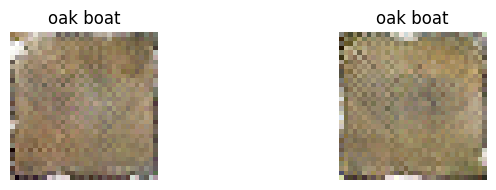

Epoch 1100/2000 | Loss: 0.0962


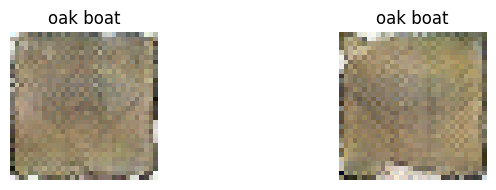

KeyboardInterrupt: 

In [9]:
# entrenamiento funcion primera version
num_epochs = 2000

for epoch in range( num_epochs):
    model.train()
    total_loss = 0

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        cond = txt_emb(labels).to(device)

        # sample random timesteps y ruido
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)
        noise = torch.randn_like(imgs)

        alpha_bar_t = model.alphas_cumprod[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * imgs + torch.sqrt(1 - alpha_bar_t) * noise
        
        noise_pred = model(x_t, t, cond)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # =========================================================
    # LOGGING
    # =========================================================   
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs} | Loss: {total_loss / len(dataloader):.4f}")

        # Generar una imagen de ejemplo condicional
        test_prompt = "oak boat"
        imgs_gen = generar_imagenes(model, txt_emb, test_prompt, n_samples=2)
        mostrar_resultados(imgs_gen)
        

#### resultados

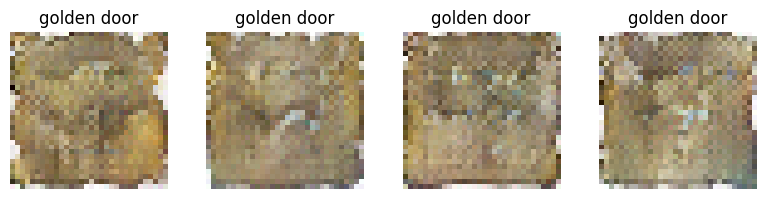

In [10]:
prompt = "golden door"
imgs = generar_imagenes(model, txt_emb, prompt)
mostrar_resultados(imgs)


#### Guardar modelos

In [ ]:
# GUARDAR MODELOS
import os
import torch

version = "v3"
save_dir = f"./DDIM/{version}"
os.makedirs(save_dir, exist_ok=True)


torch.save(model.state_dict(), os.path.join(save_dir, "diffusion_model.pth"))
torch.save(txt_emb.state_dict(), os.path.join(save_dir, "text_embedding.pth"))

# guardamos hiperparámetros y vocabulario
metadata = {
    "embed_dim": embed_dim,
    "timesteps": timesteps,
    "ch_base": ch_base,
    "vocab": txt_emb.vocab,}

torch.save(metadata, os.path.join(save_dir, "metadata.pth"))

print(f" Modelos y metadatos guardados en: {save_dir}")



 Modelos y metadatos guardados en: ./DDIM/v3


#### Importar modelos

In [ ]:
import torch
import os

# Configuración
device = "cuda" if torch.cuda.is_available() else "cpu"
version = "v2"  
save_dir = f"./modelos/{version}"

# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))
vocab = TextEmbedding.build_vocab(all_labels)

metadata = torch.load(os.path.join(save_dir, "metadata.pth"))
txt_emb = TextEmbedding(vocab=vocab, embed_dim=metadata["embed_dim"]).to(device)
model = MiniUNet(cond_dim=metadata["embed_dim"], base_ch=metadata["ch_base"], timesteps=metadata["timesteps"]).to(device)

# === Cargar pesos ===
model.load_state_dict(torch.load(os.path.join(save_dir, "diffusion_model.pth"), map_location=device))
txt_emb.load_state_dict(torch.load(os.path.join(save_dir, "text_embedding.pth"), map_location=device))

print(" Modelos cargados correctamente desde", save_dir)


 Modelos cargados correctamente desde ./DDIM/v2


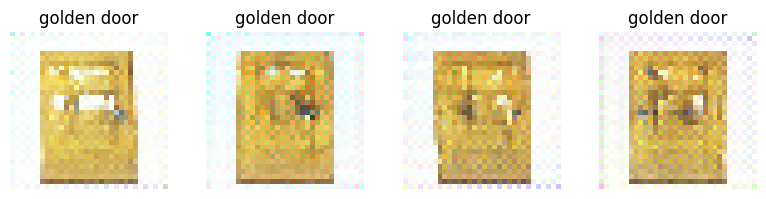

In [16]:
prompt = "golden door"
imgs = generar_imagenes(model, txt_emb, prompt)
mostrar_resultados(imgs)
